# Prediction Model for Term Deposit Subscriptions

The notebook focuses on tree-based methods for the following reasons:
1. they are well-suited for categorical attributes
2. they are robust to outliers, data skew, and the scale of features
3. can model non-linear decision boundaries

This simplifies data preprocessing as skew reduction, feature scaling, outlier removal, and one-hot encoding are not strictly necessary. A more elaborate version of this notebook could explore neural network architectures. This, however, would require the preprocessing steps mentioned before.

### Trained models

1. Decision Tree (scikit-learn)
2. Random Forest (scikit-learn)
3. Gradient Boosting (scikit-learn)
4. CatBoost
5. XGBoost

### Evaluation metrics

**Selected metrics**

Since the label distribution is highly imbalanced, accuracy is no suitable metric. Instead, I suggest to focus on
- precision
    - proportion of positive predictions that are actually positive
- recall / sensitivity
    - true positive rate
    - proportion of true positives detected by the classifier
- F1 score
    - harmonic mean of precision and recall
    - (2 * precision * recall) / (precision + recall)

These metrics are well-suited for imbalanced classification and also provide useful insights in the types of errors the model makes (false positives / false negatives). This allows choosing the best model based on the task requirements.

For instance, I assume that missing out on a term deposit (false negative) is more expensive than contacting a customer who's not interested (false positive). Precision and recall provide insights into these kinds of classification errors.

In general, F-scores allow taking into account the cost of false positives and false negatives by computing the more general F-beta score.
- e.g., if beta=2, recall is twice as important as precision.

**Alternatives**
- ROC-AUC
    - area under the receiver operating characteristic (ROC) curve
    - allows finding a threshold that best separates both classes
    - harder to interpret than precision and recall. Hence, I'd stick to precision, recall, F1.
- Balanced accuracy
    - also well suited for imbalanced classification
    - (sensitivity + specificity) / 2
    - I assume that high recall is more important than high specificity (true negative rate). However, balanced accuracy weighs them both equally. Hence, based on my understanding of the task, I would not rely on this metric to select the final classifier.

### EDA and preprocessing:

The points below summarize the eda and preprocessing performed in this notebook:

1. imports
2. load and store dataset
3. Xy.info()
4. Xy.desribe()
5. handle null values
6. check for duplicates
7. drop the duration column
8. basic feature engineering
    - add `success_rate` and `balance_per_age`
9. encode categorical
    - convert object-type columns to categorical (also date columns, as numeric encoding appears to hurt performance).
        - Note that sklearn algorithms will treat all columns as numerical, but we also use CatBoost and XGBoost
    - we will use label encoding as we will train tree-based models, but other models might require other encoding techniques such as one-hot encoding
10. check attribute cardinality
11. plot distribution of numeric attributes grouped by y
12. check for outliers
13. handle skew (not required for tree-based models)
14. handle multi-collinearity (not required for tree-based models)
15. inspect label distribution
    - balanced / imbalanced?
        - affects suitable metrics and whether to experiment with resampling techniques like SMOTE
16. drop redundant / low-importance features (optional)

### Model training
1. imports
2. define training functions
3. set up models (and evaluated hyperparameter combinations)
4. split data into train and test sets
5. remove outliers from train data (optional)
6. data scaling / normalization (not required for tree-based models)
7. train models
	- optional: training + hyperparameter tuning
8. inspect results
9. train models on balanced data
	- apply SMOTE to training data
	- train models on balanced training data
	- evaluate on original, imbalanced test data
10. inspect results
11. join all results and identify best-performing model
12. save best model


## Other information to consider usually available to banks:

#### Information related to customer
1. **gender**
    - useful only if different genders respond differently to marketing campaigns
2. **nationality**
    - useful only if different nationalities respond differently to marketing campaigns
2. **whether the customer has already invested in the past**
    - could indicate if the customer is interested in investing
3. **the customer's risk aversion**
    - customers with low risk aversion might prefer other investment options (e.g., stocks) while customers with high risk aversion might opt for safer investments.
4. **the customer's minimum balance over the past year**
    - indicates whether the customer has a certain amount of money "lying around" that could be invested
6. **cashflow**
    - the customer's monthly cashflow
    - contains information about income and spendings
    - might not be the most predictive feature but worth giving a try if easily available

#### Information about environment and product

1. **the offered interest rate**
    - higher interest rates are likely more successful
2. **interest rates of competitors**
    - if competitors offer significantly higher interest rates, clients are more likely to decline the term deposit.
3. **average stock market performance over the last year (short-term) or 5 years (longer-term)**
    - if the stock market performed poorly, customers might be drawn to term deposits


## Insights useful for other bank departments?

1. customer acquisition and targeted marketing
    - `age` is one of the most predictive columns in the data
    - one could use such demographic information to target these groups of customers in marketing campaigns
3. market research
    - one could develop prediction models for similar investment products (e.g., stocks), not only fixed term deposits. By comparing the output of the models, one could find out whether different groups of customers prefer different investment products. For instance, young, unmarried customers might opt for higher-risk investments while older, married customers might opt for safer investments.
    - one could then make better decisions about which investment product to advertise to which customer
3. development of investment products
    - higher interest rates for the fixed term deposit likely lead to more successful marketing campaigns.
    - however, higher interest rates are also more expensive for the bank.
    - one could use the insights to optimize the offered interest rate (as low as possible but as high as required to still convince customers)



In [1]:
import os

import numpy as np
import pandas as pd
from debugpy.server.cli import TARGET
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ucimlrepo import fetch_ucirepo

from utils.column_names import *
from config.paths import *


In [2]:
filepath = os.path.join(DATA_DIR, "data.parquet")

def load_data(local_storage_url: str | None = None) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    def fetch_data() -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
        # fetch dataset
        bank_marketing = fetch_ucirepo(id=222)

        # data (as pandas dataframes)
        X_raw = bank_marketing.data.features
        y_raw = bank_marketing.data.targets

        Xy = X_raw.copy()
        Xy[TARGET] = y_raw

        return X_raw, y_raw, Xy

    if local_storage_url is None:
        return fetch_data()
    elif os.path.exists(local_storage_url):
        Xy = pd.read_parquet(local_storage_url)
        y_raw = Xy[TARGET]
        X_raw = Xy.drop([TARGET], axis=1)
        return X_raw, y_raw, Xy
    else:
        os.makedirs(os.path.dirname(local_storage_url), exist_ok=True)
        X_raw, y_raw, Xy = fetch_data()
        Xy.to_parquet(local_storage_url)
        return X_raw, y_raw, Xy

_, _, Xy = load_data(local_storage_url=filepath)

print(f"The dataset has {len(Xy)} observations and {len(Xy.columns) - 1} features")

The dataset has 45211 observations and 16 features


In [3]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
Xy.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Check if `X` has null values.

In [5]:
Xy.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

In [6]:
# Percentage of null values
(Xy.isnull().sum() / len(Xy) * 100).round(1)

age             0.0
job             0.6
marital         0.0
education       4.1
default         0.0
balance         0.0
housing         0.0
loan            0.0
contact        28.8
day_of_week     0.0
month           0.0
duration        0.0
campaign        0.0
pdays           0.0
previous        0.0
poutcome       81.7
y               0.0
dtype: float64

We can now fill missing values and doublecheck that this was successful. Pay attention to drop rows from Xy in order to keep X and y aligned!

- `job` only has 0.6% null-values. We drop these rows
- `education` has 4.1% null-values. We add another category "unknown", describing that no information about the education type was available
- `contact` has 28.8% null-values. We add another category "unknown", describing that no information about the contact type was available
- `poutcome` has 81.7% null-values. We add another category "NA", describing that the client has not been subject to a previous marketing campaign

In [7]:
def fill_na(df: pd.DataFrame) -> pd.DataFrame:
    return (df
            .fillna(value={CONTACT: "unknown", EDUCATION: "unknown", POUTCOME: "NA"} ,inplace=False)
            .dropna(subset=JOB, axis=0, inplace=False)
            )

Xy = fill_na(Xy)

# doublecheck that it worked
Xy.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

In [8]:
def drop_duration(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop("duration", axis=1)

Xy = drop_duration(Xy)

The data contains 16 duplicates:

In [9]:
Xy.duplicated().sum()

np.int64(16)

In [10]:
Xy.loc[Xy.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,y
2871,44,services,single,secondary,no,0,yes,no,unknown,14,may,1,-1,0,NA,no
4910,34,management,single,tertiary,no,0,yes,no,unknown,21,may,1,-1,0,NA,no
12939,25,blue-collar,married,primary,no,0,no,no,cellular,7,jul,1,-1,0,NA,no
13662,47,services,married,secondary,no,0,yes,no,cellular,9,jul,1,-1,0,NA,no
15836,35,management,married,tertiary,no,0,yes,no,cellular,21,jul,3,-1,0,NA,no
21522,47,technician,married,secondary,no,0,no,no,cellular,19,aug,2,-1,0,NA,no
22157,31,management,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,NA,no
22210,32,technician,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,NA,no
22233,34,management,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,NA,no
22418,30,technician,single,tertiary,no,0,no,no,cellular,22,aug,2,-1,0,NA,no


In [11]:
Xy.drop_duplicates()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,NA,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,NA,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,NA,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,NA,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,NA,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,NA,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,NA,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,NA,no


Remove the `duration` column as it should not be used as a predictive feature

> last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Next, perform basic feature engineering:
1. `success_rate`
    - indicator(poutcome==success) / number of contacts in previous campaign
2. `balance_per_age`
    - a customer's balance divided by their age

In [12]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds additional features to the dataset:
    `success_rate`, `balance_per_age`, and `long_campaign`
    :param df: the dataframe to add the features to
    :return: the dataframe with additional features
    """
    df = df.copy()

    # previous == 0 causes division by 0 --> fill with -1 (success_rate otherwise >= 0)
    df[SUCCESS_RATE] = ((df[POUTCOME] == "success").astype(float) / df[PREVIOUS]).fillna(-1)

    log_balance = np.log1p(df[BALANCE].abs()- np.min(df[BALANCE]))  # the balance distribution is skewed, so we take the log on the shifted data
    df[BALANCE_PER_AGE] = (log_balance / df[AGE]).astype(float)

    return df

Xy = add_features(Xy)

Next, encode the date columns and target columns as integer category

In [13]:
def encode_categorical(df: pd.DataFrame, columns: list) -> (pd.DataFrame, dict):
    cpy = df.copy()
    mapping = {}
    for col in columns:
        le = LabelEncoder()
        cpy[col] = le.fit_transform(cpy[col])
        cpy[col] = cpy[col].astype("category")
        mapping[col] = {decoded: encoded for decoded, encoded in zip(le.classes_, le.transform(le.classes_))}
    return cpy, mapping

Xy, mapping = encode_categorical(Xy, columns=categorical_columns + date_columns + [TARGET])

In [14]:
mapping

{'job': {'admin.': np.int64(0),
  'blue-collar': np.int64(1),
  'entrepreneur': np.int64(2),
  'housemaid': np.int64(3),
  'management': np.int64(4),
  'retired': np.int64(5),
  'self-employed': np.int64(6),
  'services': np.int64(7),
  'student': np.int64(8),
  'technician': np.int64(9),
  'unemployed': np.int64(10)},
 'marital': {'divorced': np.int64(0),
  'married': np.int64(1),
  'single': np.int64(2)},
 'education': {'primary': np.int64(0),
  'secondary': np.int64(1),
  'tertiary': np.int64(2),
  'unknown': np.int64(3)},
 'default': {'no': np.int64(0), 'yes': np.int64(1)},
 'housing': {'no': np.int64(0), 'yes': np.int64(1)},
 'loan': {'no': np.int64(0), 'yes': np.int64(1)},
 'contact': {'cellular': np.int64(0),
  'telephone': np.int64(1),
  'unknown': np.int64(2)},
 'poutcome': {'NA': np.int64(0),
  'failure': np.int64(1),
  'other': np.int64(2),
  'success': np.int64(3)},
 'day_of_week': {np.int64(1): np.int64(0),
  np.int64(2): np.int64(1),
  np.int64(3): np.int64(2),
  np.int64

Last, let's inspect the cardinality of the attributes
- notably, `day_of_week` actually seems to be the day of the month as it has 31 distinct values.

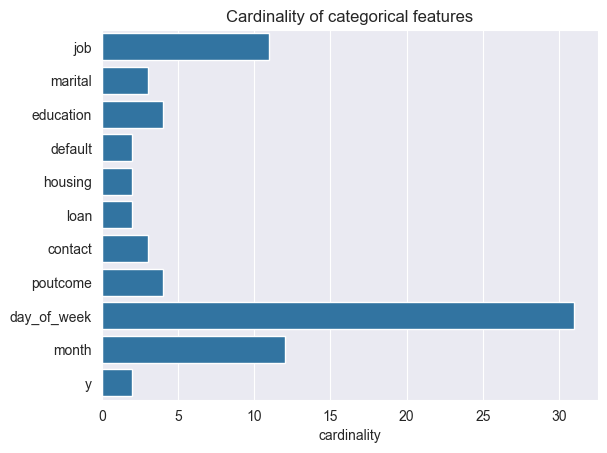

In [15]:
frequencies_categorical = pd.DataFrame(
    [{"column": col, "cardinality": len(pd.unique(Xy[col]))} for col in categorical_columns + date_columns + [TARGET]],
)

ax = sns.barplot(frequencies_categorical, x="cardinality", y="column")
ax.set_ylabel("")
ax.set_title("Cardinality of categorical features")
plt.show()

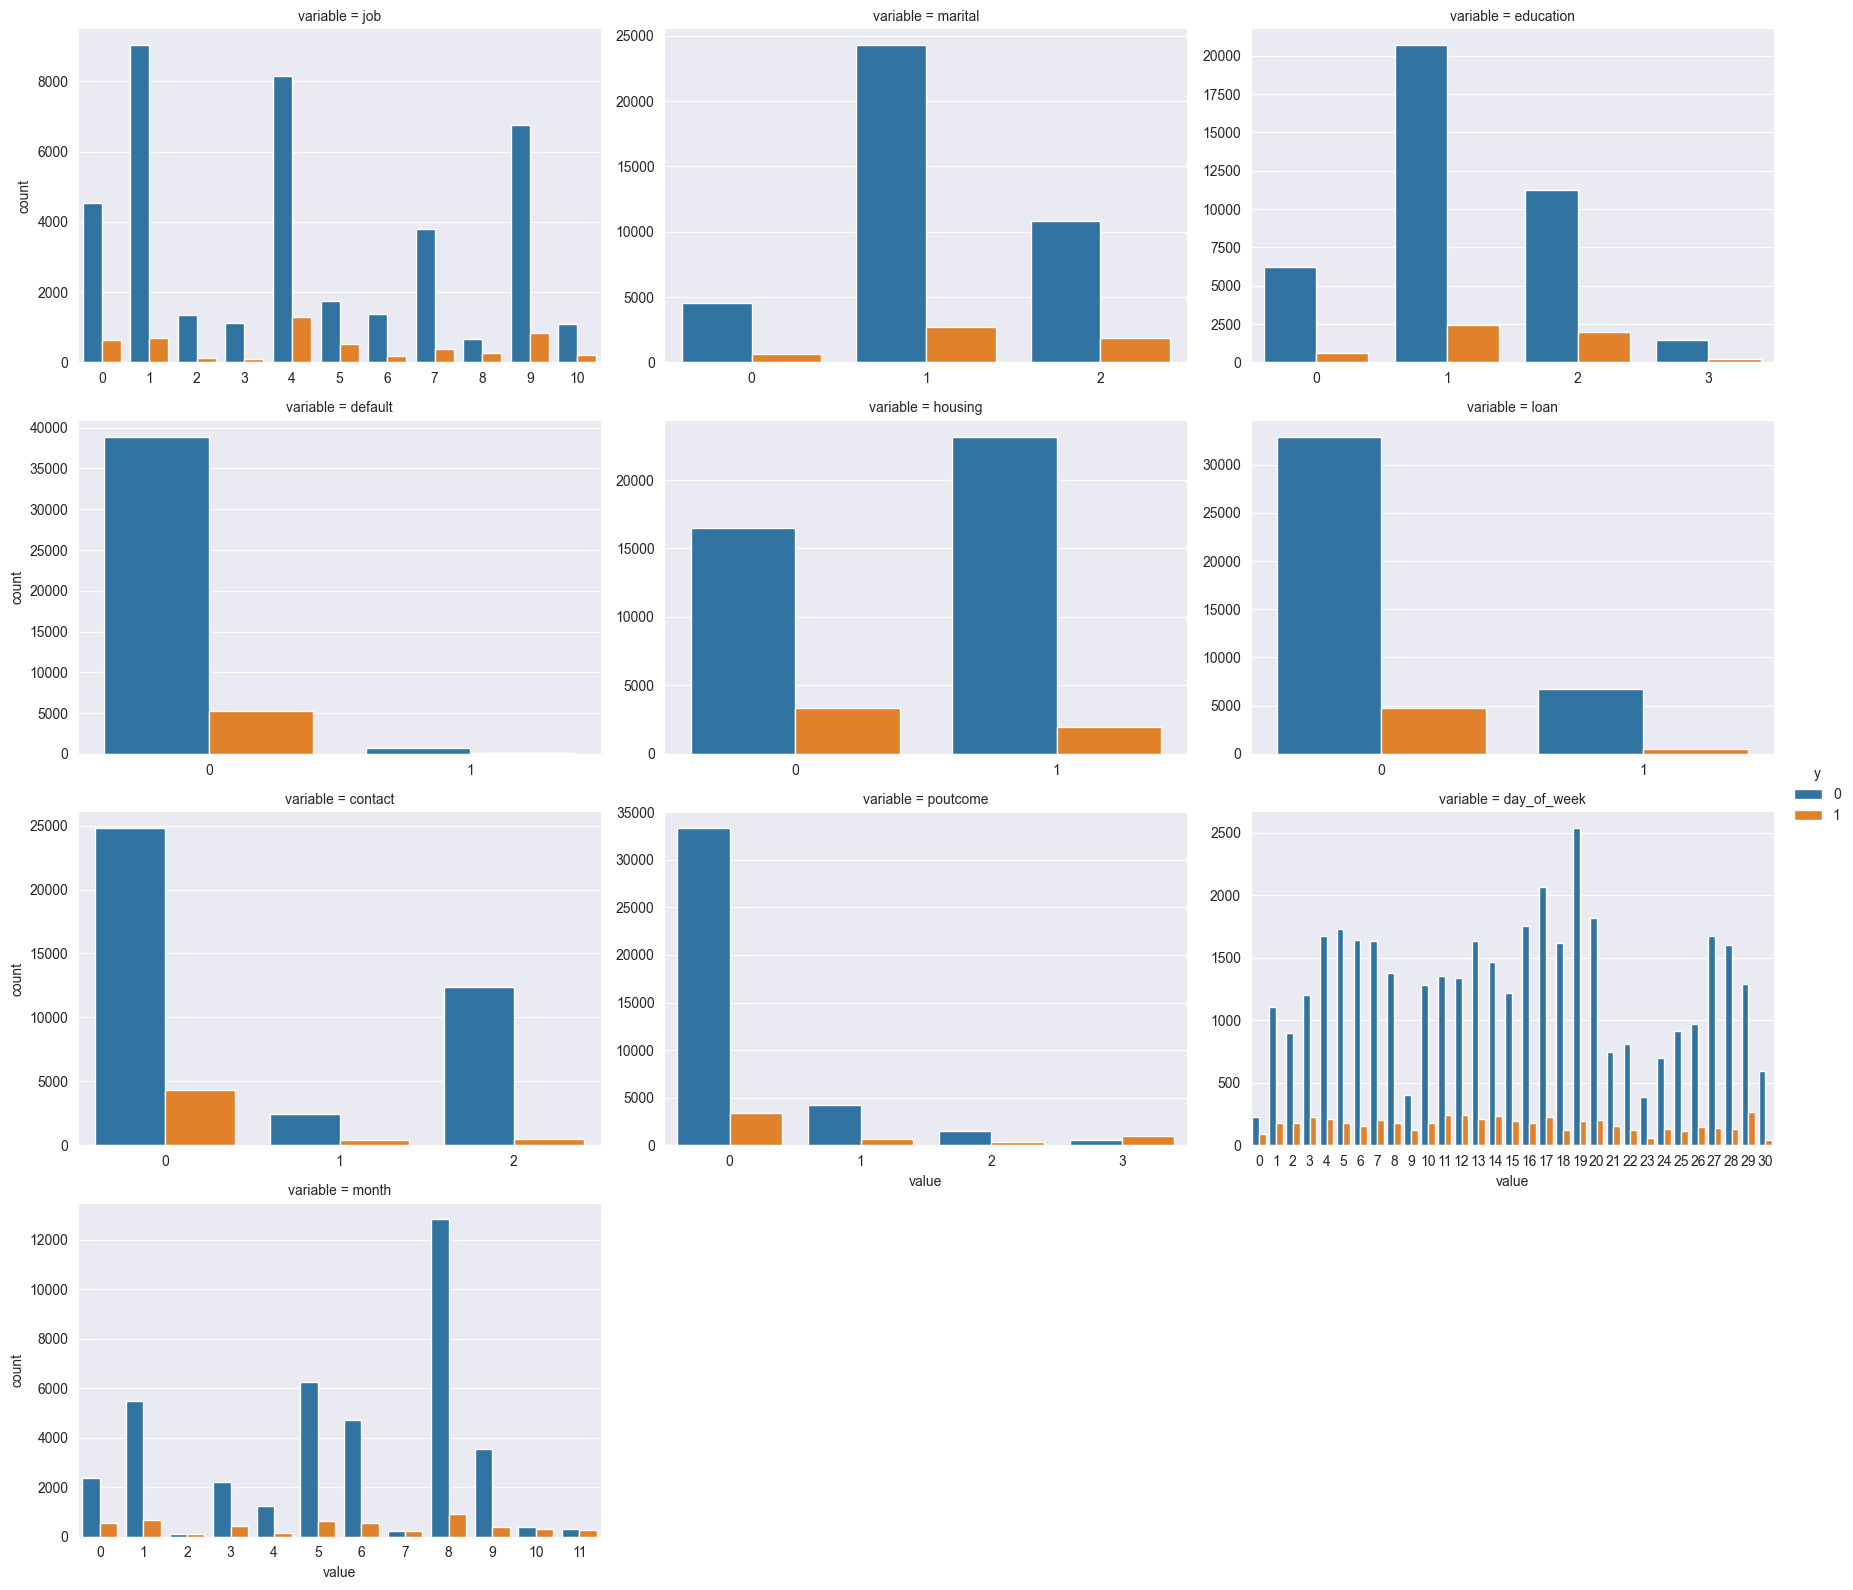

In [16]:
def plot_categorical(df: pd.DataFrame):
    melted_df = df.melt(id_vars=[TARGET], value_vars=categorical_columns + date_columns)
    sns.catplot(
        data=melted_df,
        x="value",
        hue=TARGET,
        col="variable",
        kind="count",
        col_wrap=3,         # Adjust this for layout
        height=4,
        aspect=1.5,
        sharex=False,
        sharey=False
    )
    plt.show()


plot_categorical(Xy[categorical_columns + date_columns + [TARGET]])

I also experimented with circular encoding of the date columns. However, it hurt most models, so I commented it out.

In [17]:
# def circular_encoding_dates(df: pd.DataFrame, date_cols: list) -> pd.DataFrame:
#     cpy = df.copy()
#     for col in date_cols:
#         n_unique = len(np.unique(df[col]))
#         cpy[col + "_sin"] = cpy[col].apply(lambda x: np.sin(2 * np.pi * x / n_unique)).astype(float)
#         cpy[col + "_cos"] = cpy[col].apply(lambda x: np.cos(2 * np.pi * x / n_unique)).astype(float)
#     return cpy
#
# Xy = circular_encoding_dates(Xy, date_columns)
# numerical_columns += numeric_date_columns
# Xy.head()

### Inspect numerical columns

#### Distribution plots

In [18]:
def plot_kde(df: pd.DataFrame, columns: list):
    df_num_melted = pd.melt(df, id_vars=[TARGET], value_vars=columns, var_name="column", value_name="value")

    sns.displot(data=df_num_melted, x="value", hue=TARGET, col="column",
                kind="kde", col_wrap=3,
                facet_kws={"sharey": False, "sharex": False},
                common_norm=False)
    plt.show()

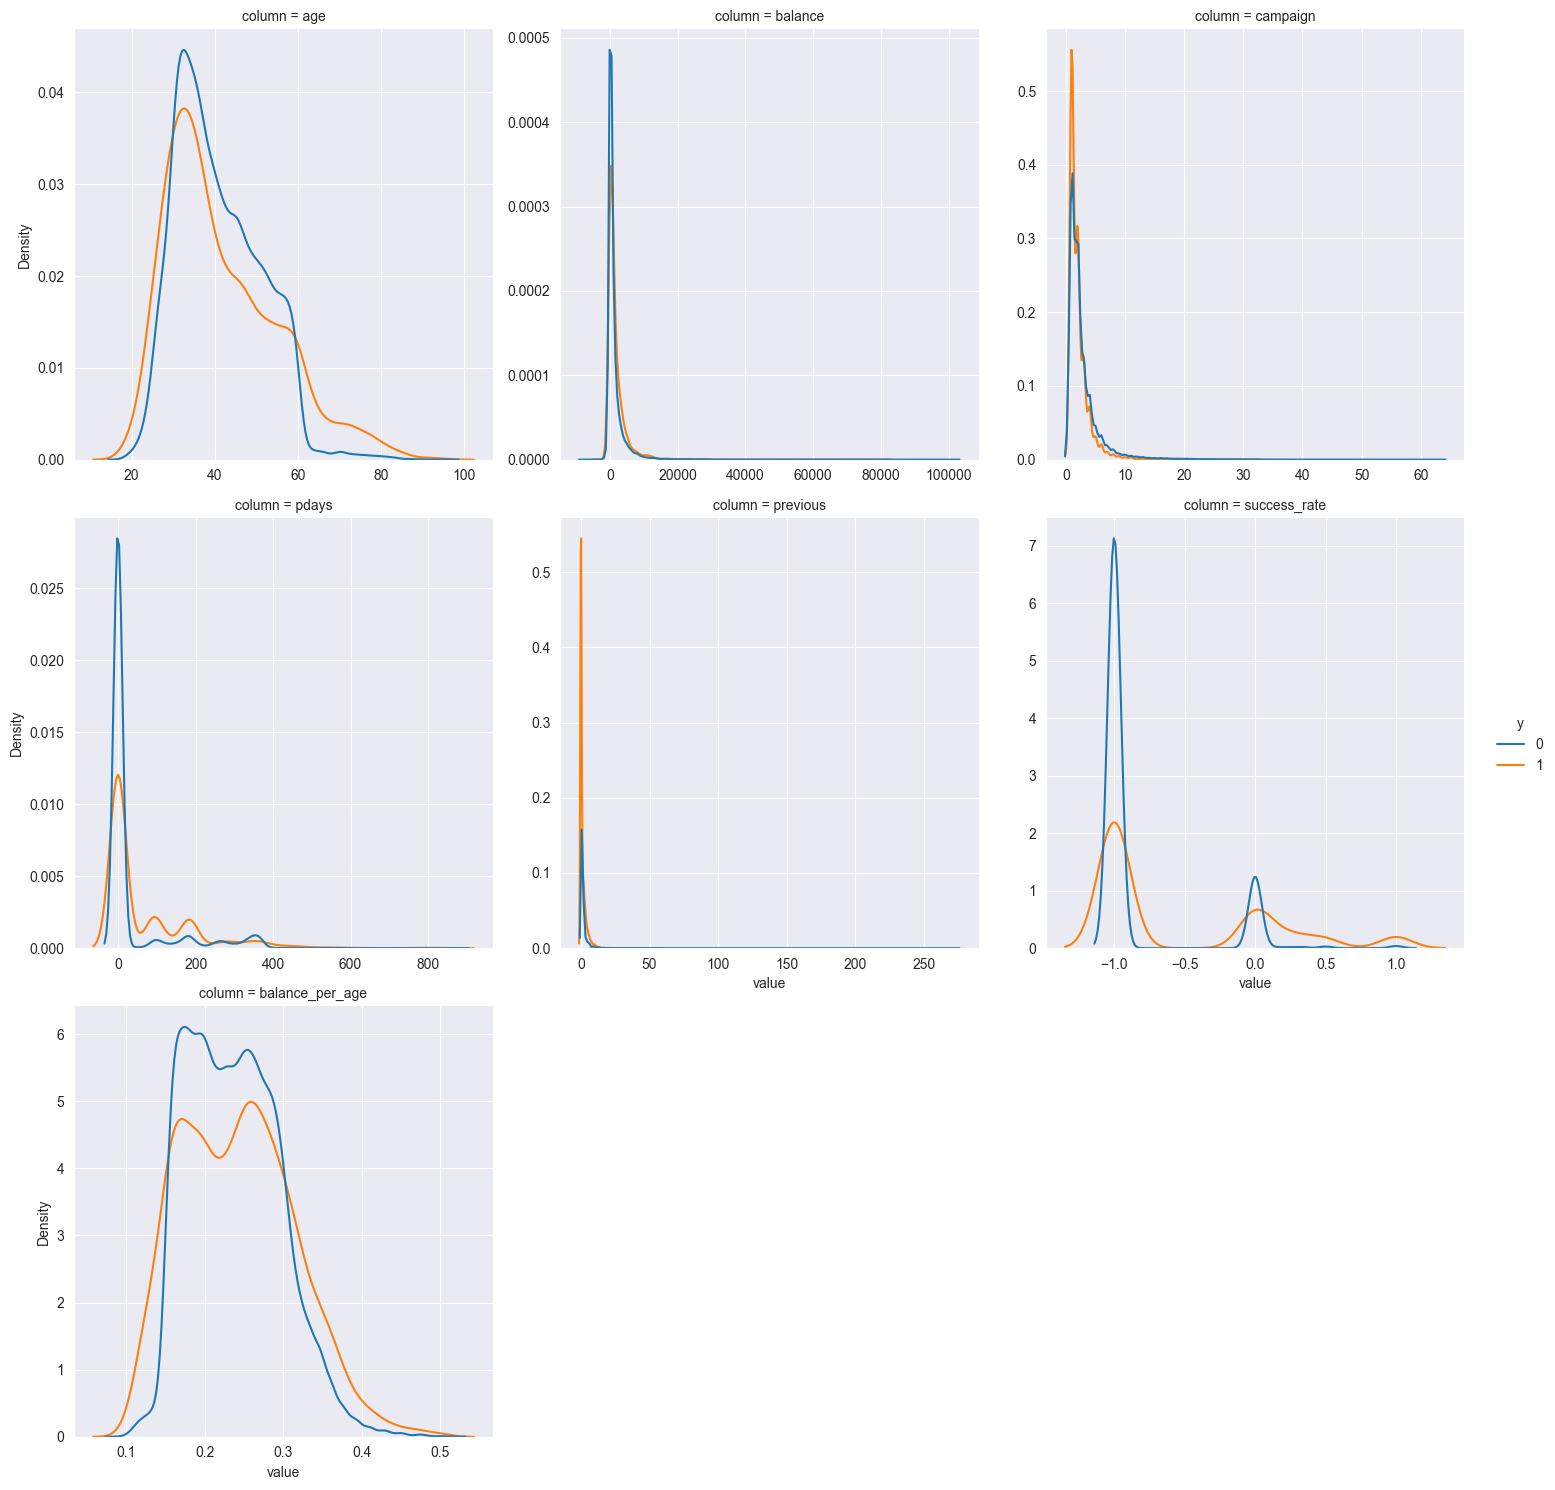

In [19]:
plot_kde(Xy, numerical_columns)

#### Outliers

We observe in the plots that the data has extreme values. However, tree-based models are quite robust to outliers, so I consider outlier removal optional in this data set.

The following function can be used to remove outliers from the data. Be careful only to apply this function after splitting the data into train and test set!

In [20]:
def remove_outliers_percentile(X: pd.DataFrame, y: pd.Series, considered_columns: list, percentile: float, greater_than: bool = True) -> (pd.DataFrame, pd.Series):
    thresholds = {col: np.percentile(X[col], percentile) for col in considered_columns}
    mask = np.ones(len(X), dtype=bool)
    for col, threshold in thresholds.items():
        if greater_than:
            mask[X[col] > threshold] = False
        else:
            mask[X[col] < threshold] = False
    return X.loc[mask], y[mask]

#### Skew
Let's examine the skew in the data:

In [21]:
print(Xy[numerical_columns].skew())

age                 0.689220
balance             8.390123
campaign            4.911021
pdays               2.607905
previous           41.802703
success_rate        1.960919
balance_per_age     0.476657
dtype: float64


`previous` is heavily skewed, so I apply log-transformation to reduce skew. However, the effect is low, as tree-based models are rather robust to skew.

In [22]:
# def reduce_skew(df: pd.DataFrame, considered_columns: list) -> pd.DataFrame:
#     df = df.copy()
#     for col in considered_columns:
#         df[col] = np.log1p(df[col])
#     return df
#
#
# Xy = reduce_skew(Xy, considered_columns=[PREVIOUS, CAMPAIGN])
# print(Xy[numerical_columns].skew())

#### Multi-collinearity

Next, let's check for multi-collinearity.

Multi-collinearity is not a huge problem for tree-based models, but we might be able to use the information to remove redundant features.

In [23]:
def compute_vif(df: pd.DataFrame, considered_attributes: list):
    X = df[considered_attributes].copy()
    X = add_constant(X)  # intercept column

    vif = pd.DataFrame({
        "Feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

    return vif[vif["Feature"] != "const"]

compute_vif(Xy, numerical_columns)

,Feature,VIF
1,age,11.215267
2,balance,1.086849
3,campaign,1.014409
4,pdays,3.127773
5,previous,1.334834
6,success_rate,3.301053
7,balance_per_age,11.094900


Most features are only weakly correlated, except
- `success_rate` and `pdays`, which show medium correlation.
- `age` and `balance_per_age`, which show a high negative correlation. This is expected as `balance_per_age` was derived from the `age` attribute.

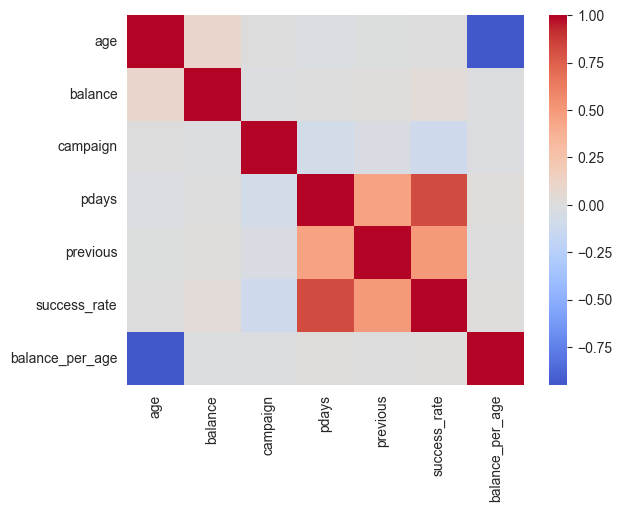

In [24]:
sns.heatmap(Xy[numerical_columns].corr(), cmap="coolwarm", center=0)
plt.show()

Based on the multi-collinearity and correlation of the attributes, one could decide to remove one of the affected attributes. However, I decide to keep both, as it does not seem to have a negative effect on performance.

### Label distribution

The label distribution is highly imbalanced
- Experiment with oversampling techniques!

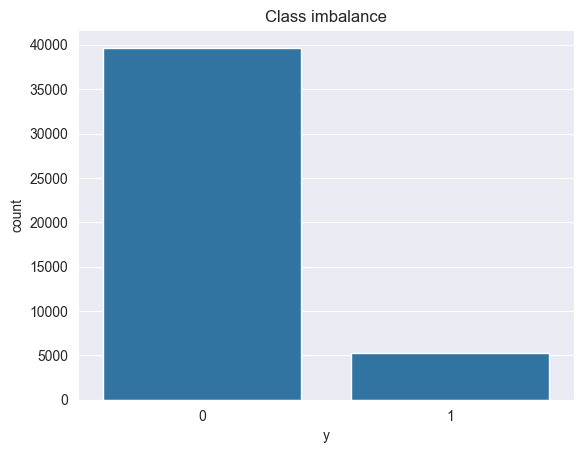

In [25]:
ax = sns.barplot(Xy[TARGET].value_counts())
ax.set_title("Class imbalance")
plt.show()

## Model Training

In [26]:
import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, roc_auc_score

#### Training functions

1. `train_model`:
    - trains a given `model` with its default parameters on train data and evaluate it on test_data
        - function parameters `parameters`, `n_iter`, `seed`, and `n_folds` are ignored in this function and only serve for API consistency with function `train_and_tune_model`.
2. `train_and_tune_model`:
    - trains a given `model` and simultaneously performs randomized hyperparameter search with `n_folds`-cross validation. The function evaluates `n_iter` different hyperparameter combinations. `seed` specifies the random state of scikit-learn's `RandomizedSearchCV`. Parameters is the dictionary in the form of `{hyperparameter: choices}`. This function is a drop-in replacement for `train_model`.

In this notebook, I only apply `train_model`, due to the runtime. However, before deploying the model in production, one should tune the hyperparameters with `train_and_tune_model`.

In [27]:
def train_model(model, model_name: str,
                parameters: dict,  # ignored but kept for API consistency
                X_train: pd.DataFrame, y_train: pd.Series,
                X_test: pd.DataFrame, y_test: pd.Series,
                n_iter: int = 20, seed: int = 42, n_folds: int = 10  # ignored but kept for API consistency
                ):
    """
    Train the model with default parameters
    """
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    metrics = {
        "model": model_name,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "balanced_accuracy": balanced_accuracy,
        "roc_auc": roc_auc,
    }
    return clf, None, metrics


def train_and_tune_model(model, model_name: str, parameters: dict,
                X_train: pd.DataFrame, y_train: pd.Series,
                X_test: pd.DataFrame, y_test: pd.Series,
                n_iter: int = 20, seed: int = 42, n_folds: int = 10):
    """
    Train and tune the model using random search cross validation
    """
    rscv = RandomizedSearchCV(estimator=model, param_distributions=parameters, scoring="roc_auc",
                              n_iter=n_iter, cv=n_folds, random_state=seed, n_jobs=-1)
    rscv.fit(X_train, y_train)
    y_pred = rscv.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, rscv.predict_proba(X_test)[:, 1])
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    metrics = {
        "model": model_name,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "balanced_accuracy": balanced_accuracy,
        "roc_auc": roc_auc,
    }
    return rscv.best_estimator_, rscv.best_params_, metrics

### Evaluated models

Define the evaluated models and hyperparameter spaces

Each item `evaluated_models` is a triple of (model name, model, hyperparameter grid). Note that the grid can be left empty when using `train_model` instead of `train_and_evaluate_model`.


In [28]:
evaluated_models = [
    ("DecisionTree", DecisionTreeClassifier(random_state=42), {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
     }),
    ("RandomForest", RandomForestClassifier(random_state=42), {
        "n_estimators": [100, 200],
        "criterion": ["gini", "entropy", "log_loss"],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", 0.5, 0.75, None]
    }),
    ("GradientBoosting", GradientBoostingClassifier(random_state=42), {
        "n_estimators": [100, 200],
        "criterion": ["gini", "entropy", "log_loss"],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", 0.5, 0.75, None]
    }),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=0, cat_features=categorical_columns + date_columns), {
        "l2_leaf_reg": [None] + list(range(1, 4)),
        "bagging_temperature": [0, 0.5, 1, 2, 4]
    }),
    ("XGBoost", XGBClassifier(enable_categorical=True, random_state=42), {
        "n_estimators": [100, 200, None],
        "learning_rate": [0.05, 0.1, 0.2, None],
        "eta": [0.2, 0.3, 0.4],
        "subsample": [0.6, 0.8, 1.0],
        "lambda": [0.5, 1, 2],
        "alpha": [0.0, 0.1, 0.2]
    })
]

#### Train and test split

- split data into train and test
- remove outliers from train data (skipped here by setting `outlier_percentile = 100`)
- plot distribution of numeric train data after outlier removal

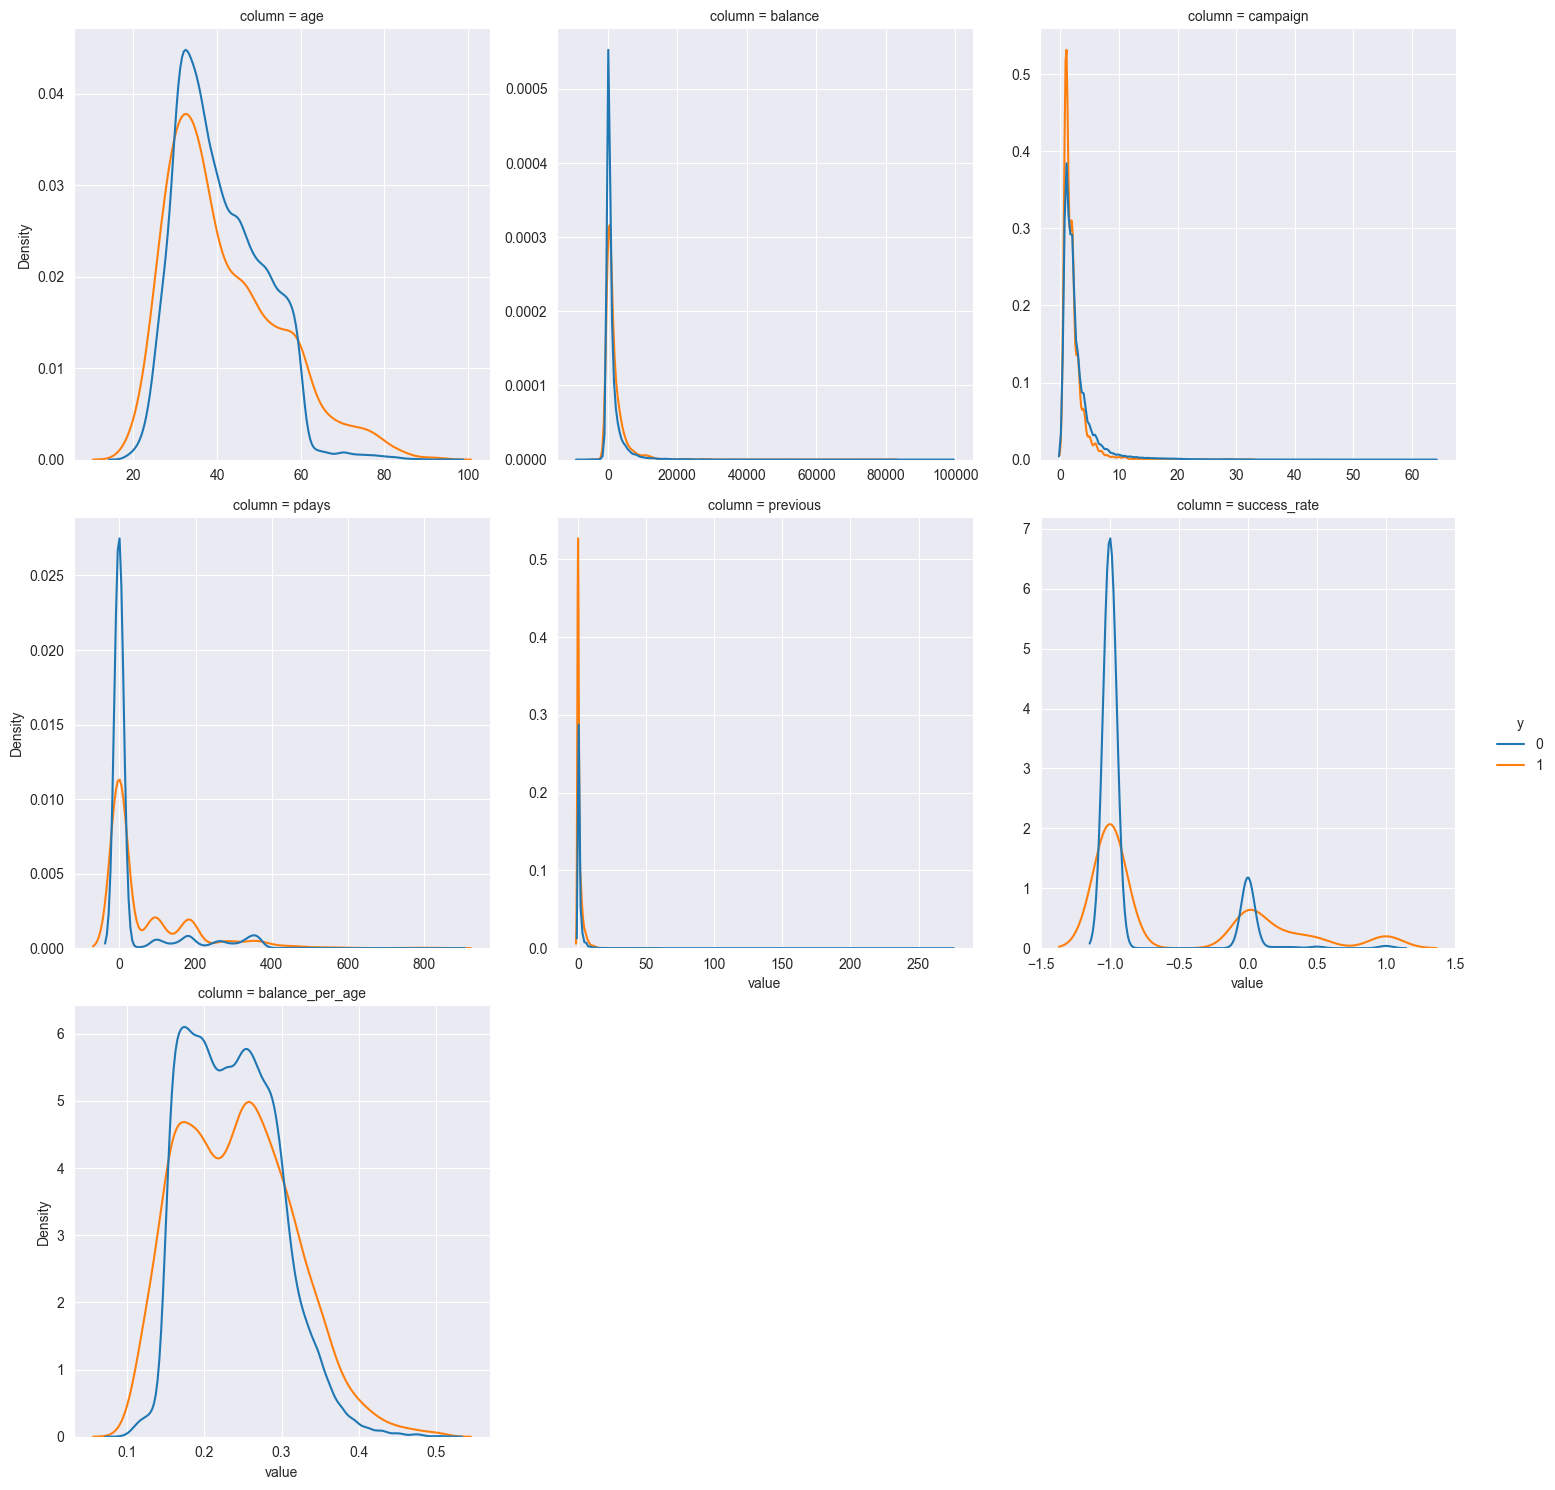

In [29]:
train_frac = 0.8
outlier_percentile = 100

y = Xy[TARGET].astype(int)
X = Xy.drop(TARGET, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_frac, random_state=42, shuffle=True)

X_train, y_train = remove_outliers_percentile(X_train, y_train,
                                              considered_columns=numerical_columns,
                                              percentile=outlier_percentile)
X_train, y_train = remove_outliers_percentile(X_train, y_train,
                                              considered_columns=numerical_columns,
                                              percentile=100 - outlier_percentile,
                                              greater_than=False)

plot_kde(pd.concat([X_train, y_train], axis=1), columns=numerical_columns)  # plot KDE of training data after removing outliers

#### Model training on imbalanced data

- Loop over `evaluated_models` and call `train_model`
- add the fitted model and the best hyperparameters to the fitted_models dictionary
- add the metrics to the `results` list
- transform the `results` to a dataframe
- visualize results in a bar plot

In [30]:
fitted_models = {}
results = []
for model_name, model, parameters in evaluated_models:
    fitted_model, best_params, metrics = train_model(model, model_name, parameters,
                                                            X_train, y_train, X_test, y_test,
                                                            n_folds=3, n_iter=15)
    fitted_models[model_name] = (fitted_model, best_params)
    results.append(metrics)

results = pd.DataFrame(results)

In [31]:
results.round(2)

,model,f1,recall,precision,balanced_accuracy,roc_auc
0,DecisionTree,0.28,0.29,0.26,0.59,0.59
1,RandomForest,0.29,0.20,0.56,0.59,0.77
2,GradientBoosting,0.29,0.19,0.62,0.59,0.77
3,CatBoost,0.35,0.25,0.59,0.61,0.79
4,XGBoost,0.34,0.25,0.53,0.61,0.77


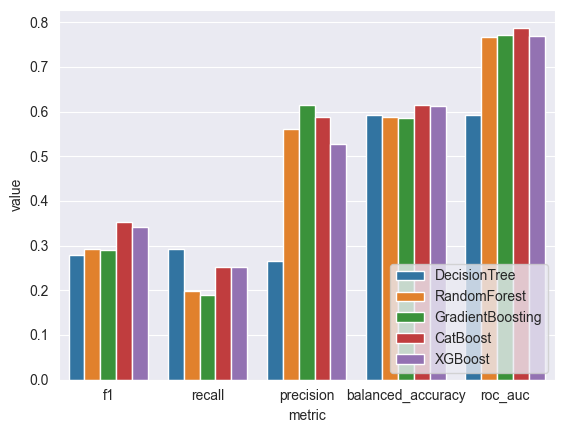

In [32]:
results_melted = pd.melt(results,
                         id_vars=["model"],
                         value_vars=["f1", "recall", "precision", "balanced_accuracy", "roc_auc"],
                         var_name="metric", value_name="value")

sns.barplot(results_melted, x="metric", y="value", hue="model")
plt.legend(loc="lower right")
plt.show()

#### Model training on balanced data

Now let's try resampling the data using SMOTE. If training on resampled data works better, we'll choose the model trained on resampled data later on. Only resample the training set!

Afterwards, apply the same steps as before:
- Loop over `evaluated_models` and call `train_model`
- add the fitted model and the best hyperparameters to the fitted_models dictionary
- add the metrics to the `results` list
- transform the `results` to a dataframe
- visualize results in a bar plot

In [33]:
from imblearn.over_sampling import SMOTENC

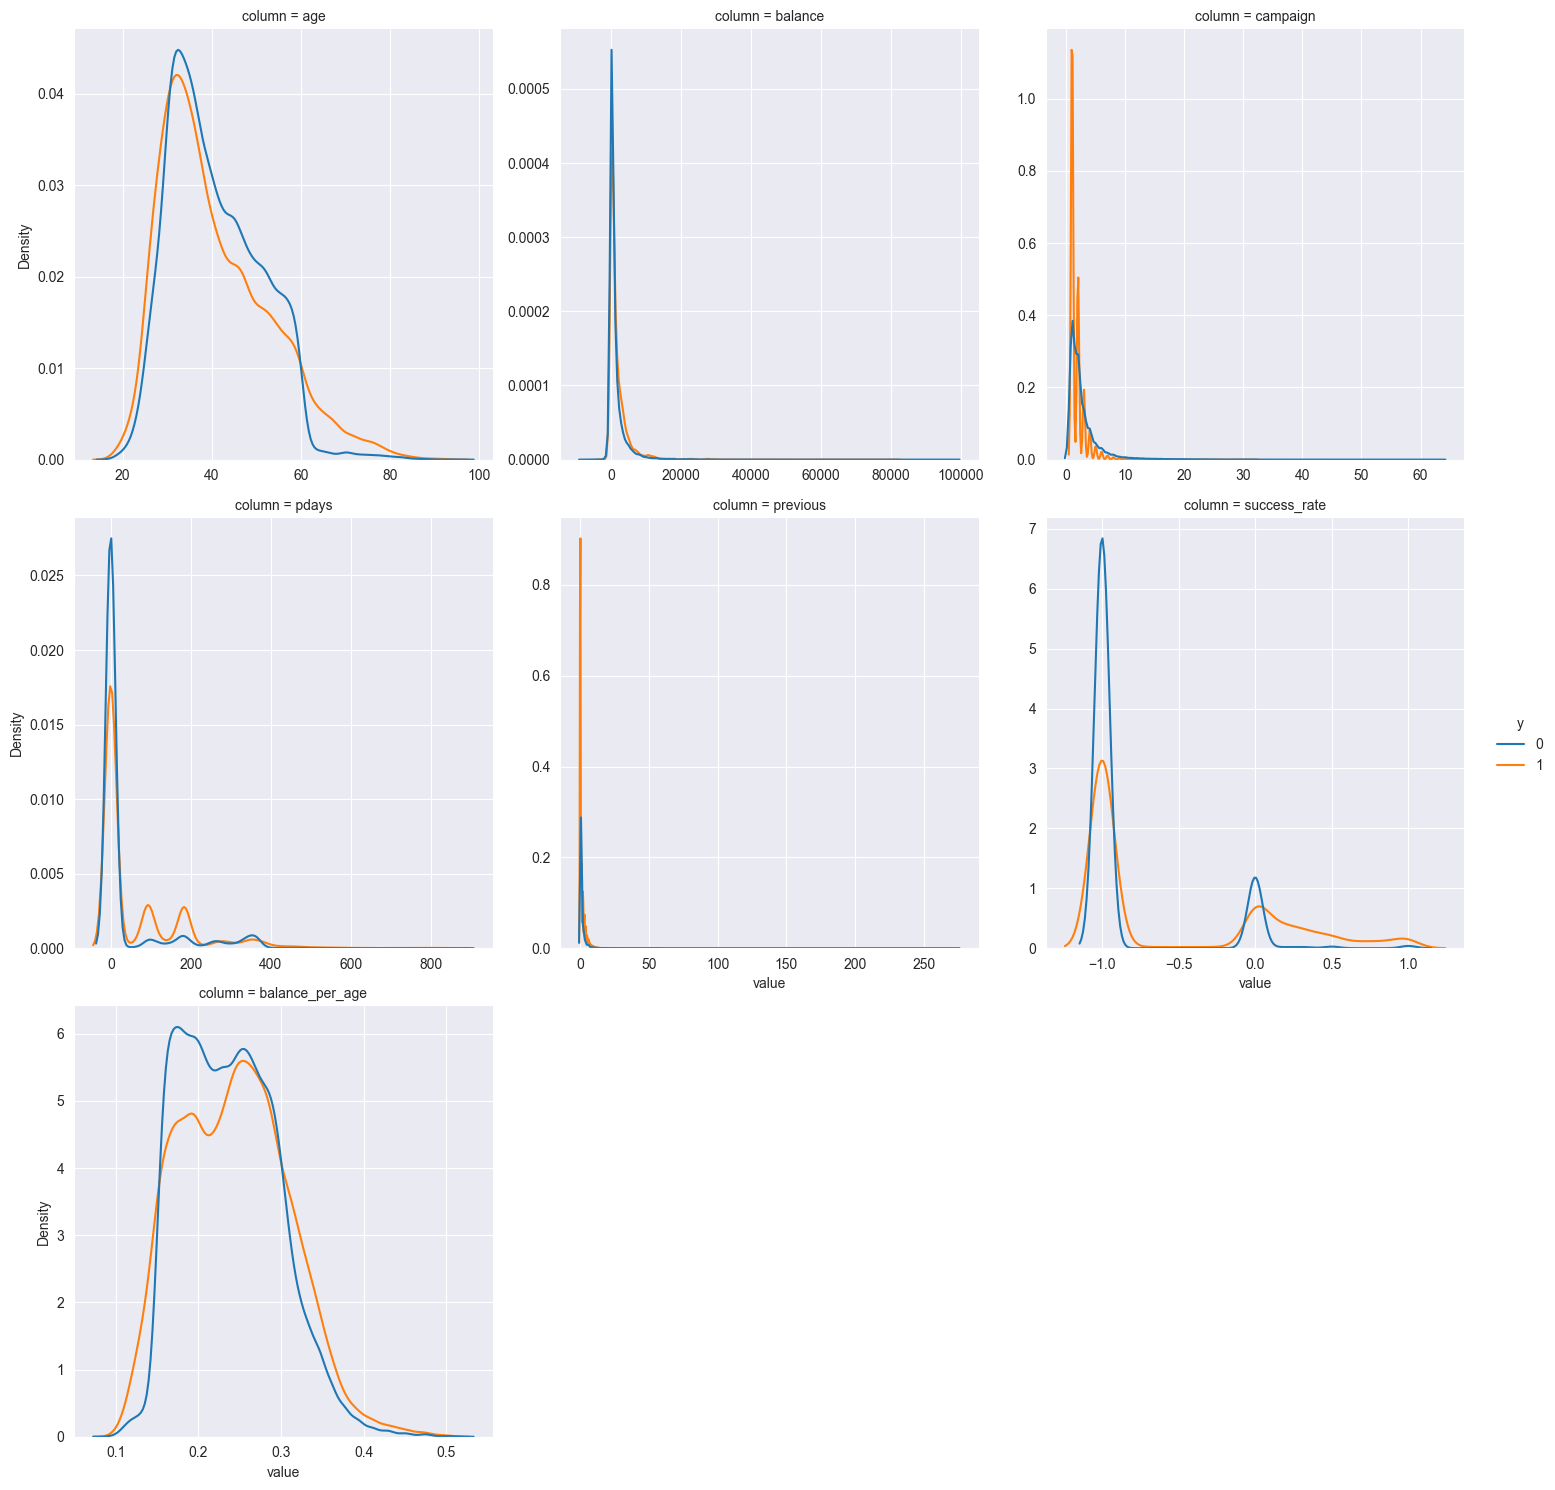

In [34]:
X_train, y_train = SMOTENC(random_state=42, categorical_features=categorical_columns + date_columns).fit_resample(X_train, y_train)

# KDE plot of resampled training data
plot_kde(pd.concat([X_train, y_train], axis=1), columns=numerical_columns)

In [35]:
fitted_models_balanced = {}
results_balanced = []
for model_name, model, parameters in evaluated_models:
    model_name = model_name + " (bal.)"
    best_model, best_params, metrics = train_model(model, model_name, parameters,
                                                            X_train, y_train, X_test, y_test,
                                                            n_folds=3, n_iter=15)
    fitted_models_balanced[model_name] = (best_model, best_params)
    results_balanced.append(metrics)

results_balanced = pd.DataFrame(results_balanced)

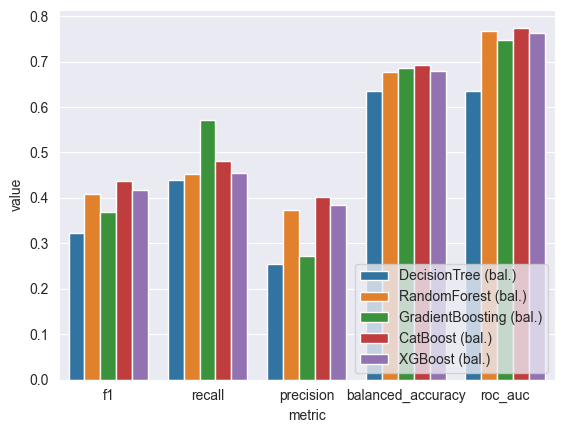

In [36]:
results_balanced_melted = pd.melt(results_balanced,
                         id_vars=["model"],
                         value_vars=["f1", "recall", "precision", "balanced_accuracy", "roc_auc"],
                         var_name="metric", value_name="value")

sns.barplot(results_balanced_melted, x="metric", y="value", hue="model")
plt.legend(loc="lower right")
plt.show()

### Final comparison

The figures and table below summarize the results of the models trained on the original data and the resampled data using SMOTE.
- Applying SMOTE boosts recall and F1, but reduces precision significantly.

Which model to select depends on the **cost of false positives and false negatives**. Most notably
- SMOTE + CatBoost achieves the highest F1-score. Choose this model if false positives and false negatives have equal costs.
- However, SMOTE + gradient boosting achieves higher recall compared to CatBoost. Hence, if the cost of false positives is low, SMOTE + CatBoost might be the best-suited model.

In [37]:
all_results = pd.concat([results, results_balanced], ignore_index=True, axis=0)
all_results.round(2)

,model,f1,recall,precision,balanced_accuracy,roc_auc
0,DecisionTree,0.28,0.29,0.26,0.59,0.59
1,RandomForest,0.29,0.20,0.56,0.59,0.77
2,GradientBoosting,0.29,0.19,0.62,0.59,0.77
3,CatBoost,0.35,0.25,0.59,0.61,0.79
4,XGBoost,0.34,0.25,0.53,0.61,0.77
5,DecisionTree (bal.),0.32,0.44,0.25,0.64,0.64
6,RandomForest (bal.),0.41,0.45,0.37,0.68,0.77
7,GradientBoosting (bal.),0.37,0.57,0.27,0.69,0.75
8,CatBoost (bal.),0.44,0.48,0.40,0.69,0.77
9,XGBoost (bal.),0.42,0.45,0.39,0.68,0.76


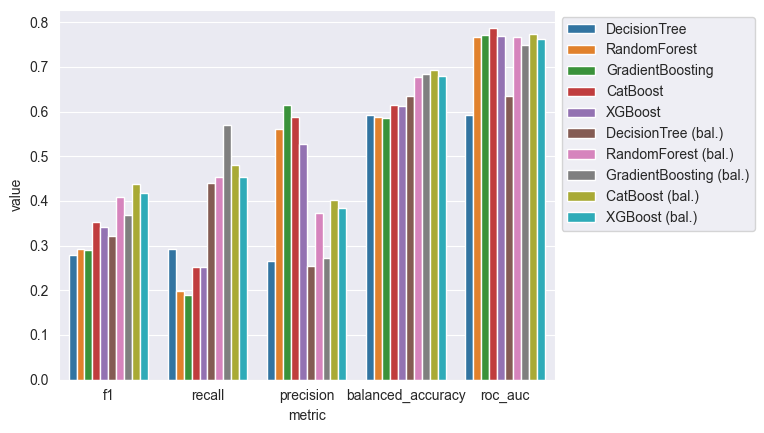

In [38]:
all_results_melted = pd.concat([results_melted, results_balanced_melted], ignore_index=True, axis=0)

sns.barplot(all_results_melted,
            x="metric", y="value", hue="model")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### Confusion matrix of CatBoost and GradientBoosting:

In [39]:
catboost = fitted_models_balanced["CatBoost (bal.)"][0]
gradient_boosting = fitted_models_balanced["GradientBoosting (bal.)"][0]

Confusion matrix for CatBoost

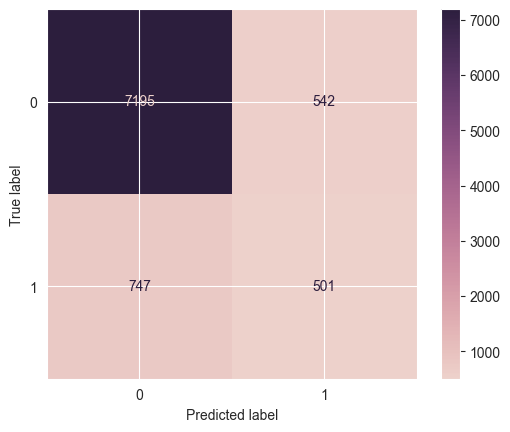

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(catboost.predict(X_test), y_test,
                                        cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Confusion matrix for GradientBoosting

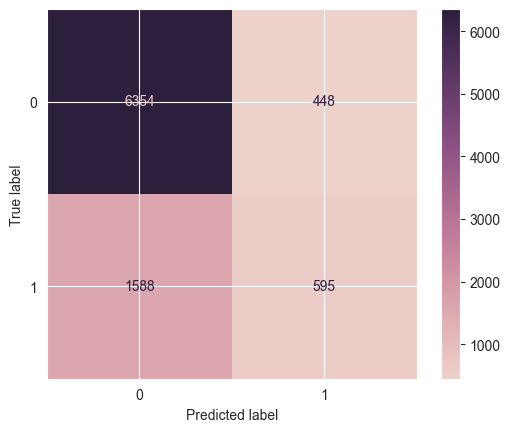

In [41]:
ConfusionMatrixDisplay.from_predictions(gradient_boosting.predict(X_test), y_test,
                                        cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

#### Feature importances:

CatBoost and GradientBoosting focus on different features. Likely, because scikit-learn's gradient boosting implementation considers all features as numeric / ordinal while catboost works well with categorical data.

In [42]:
# Catboost
cb_importance = pd.DataFrame([{"Feature": feature, "Importance": importance} for feature, importance in zip(X.columns, catboost.feature_importances_)])

cb_importance["Importance"] = cb_importance["Importance"] / np.max(cb_importance["Importance"])
cb_importance.round(2)

,Feature,Importance
0,age,1.00
1,job,0.20
2,marital,0.10
3,education,0.13
4,default,0.01
5,balance,0.45
6,housing,0.15
7,loan,0.13
8,contact,0.38
9,day_of_week,0.32


In [43]:
# GradientBoosting
gb_importance = pd.DataFrame([{"Feature": feature, "Importance": importance} for feature, importance in zip(X.columns, gradient_boosting.feature_importances_)])

gb_importance["Importance"] = gb_importance["Importance"] / np.max(gb_importance["Importance"])
gb_importance.round(2)

,Feature,Importance
0,age,0.06
1,job,0.04
2,marital,0.03
3,education,0.07
4,default,0.00
5,balance,0.10
6,housing,0.22
7,loan,0.28
8,contact,1.00
9,day_of_week,0.06


#### Store Catboost and GradientBoosting

In [44]:
catboost_path = os.path.join(MODEL_DIR, "catboost.pkl")
gb_path = os.path.join(MODEL_DIR, "gradient_boosting.pkl")

os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(catboost, catboost_path)
joblib.dump(gradient_boosting, gb_path)

['C:\\Users\\heyden\\Documents\\code\\learning\\TermDepositSubscription\\config\\..\\artifacts\\models\\gradient_boosting.pkl']

Verify that loaded models are working fine

In [45]:
catboost = joblib.load(catboost_path)
gradient_boosting = joblib.load(gb_path)

In [46]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(catboost.predict(X_test), y_test))

[[7195  542]
 [ 747  501]]


In [47]:
print(confusion_matrix(gradient_boosting.predict(X_test), y_test))

[[6354  448]
 [1588  595]]


## Further steps

The structure of this repository is already well-suited for production-ready code. However, further steps need to be done before deploying the model. These include:
- creating data preprocessing pipeline
- setting up automated experiment tracking with tools like mlflow or comet
- setting up a CI/CD pipeline with tools like docker, jenkins, and GCP.